# SIATKA 3D

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from typing import Dict, List, Tuple
import inspect
import random
from dataclasses import dataclass
from typing import Dict
import pandas as pd

In [268]:
@dataclass
class TreeType3D:
    tree_id: int
    name: str
    color: str
    p_fire: float
    burning_time: int
    max_height: int

cluster_colors = {
    0: [33, 142, 62],   
    1: [0,0,0],
    2: [9, 90, 30],    
    3: [121, 105, 87]      
}

tree_types_3d: Dict[str, TreeType3D] = {
    "EMPTY": TreeType3D(tree_id=0, name="EMPTY", color=cluster_colors[1], p_fire=0.0, burning_time=0, max_height=0),
    "Trawa": TreeType3D(tree_id=1, name="Trawa", color=cluster_colors[0], p_fire=1, burning_time=1, max_height=2),
    "Krzaki": TreeType3D(tree_id=2, name="Krzaki", color=cluster_colors[3], p_fire=0.6, burning_time=3, max_height=2),
    "Drzewa": TreeType3D(tree_id=3, name="Drzewa", color=cluster_colors[2], p_fire=0.3, burning_time=4, max_height=6)}

tree_cond = {"EMPTY": 0, "TREE": 1, "BURNING": 2, "WET_TREE": 3, "BURNED": 4}

In [ ]:
growth_rules = {
    "EMPTY": ["EMPTY"],                   # na pustym polu nic
    "Trawa": ["EMPTY", "Trawa", "Krzaki", "Drzewa"],  # na trawie może rosnąć nic, trawa, krzak lub drzewo
    "Krzaki": ["EMPTY", "Krzaki"],                # na krzaku może rosnąć tylko krzak i nic
    "Drzewa": ["EMPTY", "Drzewa"]                 # na drzewie może rosnąć tylko drzewo i nic
}

In [270]:
def get_neighbors_3d(d: int, h: int, w: int, size: Tuple[int,int,int], neighborhood: str = "moore") -> List[Tuple[int,int,int]]:
    depth, height, width = size

    if neighborhood == "von_neumann":
        offsets = [
            (-1, 0, 0), (1, 0, 0),
            (0, -1, 0), (0, 1, 0),
            (0, 0, -1), (0, 0, 1)
        ]
    elif neighborhood == "moore":
        offsets = [(dd, dh, dw)
                   for dd in [-1, 0, 1]
                   for dh in [-1, 0, 1]
                   for dw in [-1, 0, 1]
                   if not (dd == 0 and dh == 0 and dw == 0)]
    else:
        raise ValueError(f"Unknown neighborhood type: {neighborhood}")

    neighbors = [(d + dd, h + dh, w + dw) for (dd, dh, dw) in offsets
                 if 0 <= d + dd < depth and 0 <= h + dh < height and 0 <= w + dw < width]
    return neighbors

In [271]:
def forest_3D(size: tuple[int, int, int], p_tree: float,
              tree_types: dict[str, TreeType3D], growth_rules: dict, tree_ratio: list[float]) -> tuple[np.ndarray, np.ndarray]:
    
    depth, height, width = size

    name_to_id = {name: t.tree_id for name, t in tree_types.items()}
    id_to_name = {t.tree_id: name for name, t in tree_types.items()}
    
    trees = [tree_types["EMPTY"]] + [tree_types[k] for k in tree_types if k != "EMPTY"]
    probs = [1 - p_tree] + [r * p_tree for r in tree_ratio]
    assert abs(sum(probs) - 1) < 1e-8, "Suma prawdopodobieństw musi być 1!"
    
    # warstwa 0
    layer0_chosen = np.random.choice(len(trees), size=(height, width), p=probs)
    layers = np.zeros((depth, height, width), dtype=int)
    layers[0, :, :] = np.array([tree.tree_id for tree in trees])[layer0_chosen]

    for d in range(1, depth):
        for h in range(height):
            for w in range(width):
                below_tree_id = layers[d - 1, h, w]
                below_name = id_to_name[below_tree_id]
                allowed_next = growth_rules[below_name].copy()

                # Zbiór typów, które przekroczyły max_height (oprócz EMPTY)
                growth_limit_reached = set()
                for name in allowed_next:
                    if name == "EMPTY":
                        continue  # EMPTY zawsze dozwolone
                    max_height = tree_types[name].max_height
                    count = 0
                    for d_check in range(d - 1, -1, -1):
                        current_id = layers[d_check, h, w]
                        current_name = id_to_name[current_id]
                        if current_name == name:
                            count += 1
                        else:
                            break
                    if count >= max_height:
                        growth_limit_reached.add(name)

                allowed_next = [name for name in allowed_next if name not in growth_limit_reached]

                # Jeśli nic nie może urosnąć, zostaje EMPTY
                if not allowed_next:
                    chosen_id = name_to_id["EMPTY"]
                else:
                    candidate_ids = [name_to_id[name] for name in allowed_next]
                    p_candidates = np.ones(len(candidate_ids)) / len(candidate_ids)
                    chosen_id = np.random.choice(candidate_ids, p=p_candidates)

                layers[d, h, w] = chosen_id
                
    forest = (layers != name_to_id["EMPTY"]).astype(int)
    
    return forest, layers

In [272]:
def start_fire_cluster_l0(forest_before_fire: np.ndarray, neighborhood: str = "moore") -> np.ndarray:
    layers_copy = forest_before_fire.copy()
    
    plant_mask = (forest_before_fire == tree_cond["TREE"])

    # 2. Sąsiedztwo 3D
    if neighborhood == "von_neumann":
        structure = np.zeros((3,3,3), dtype=int)
        structure[1,1,0] = structure[1,1,2] = 1  # z-1, z+1
        structure[1,0,1] = structure[1,2,1] = 1  # y-1, y+1
        structure[0,1,1] = structure[2,1,1] = 1  # x-1, x+1
        structure[1,1,1] = 1
    elif neighborhood == "moore":
        structure = np.ones((3,3,3), dtype=int)
    else:
        raise ValueError(f"Nieznany typ sąsiedztwa: {neighborhood}")

    labeled, num_features = label(plant_mask, structure=structure)

    if num_features == 0:
        return layers_copy

    largest_cluster = max(range(1, num_features + 1),
                          key=lambda i: np.sum(labeled == i))

    cluster_coords = np.argwhere(labeled == largest_cluster)
    cluster_coords_layer0 = [coord for coord in cluster_coords if coord[0] == 0]

    if not cluster_coords_layer0:
        return layers_copy

    d, h, w = random.choice(cluster_coords_layer0)
    layers_copy[d, h, w] = tree_cond["BURNING"]

    return layers_copy

In [273]:
def spread_fire(forest: np.ndarray, mixed_grid: np.ndarray, wet_timer: np.ndarray, burning_time: np.ndarray,
                tree_types: Dict[str, TreeType3D], neighborhood: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    depth, height, width = forest.shape
    new_forest = forest.copy()
    new_burning_time = burning_time.copy()
    new_wet_timer = wet_timer.copy()

    id_to_tree = {t.tree_id: t for t in tree_types.values()}

    burning_indices = np.argwhere(new_forest == tree_cond["BURNING"])
    for d, h, w in burning_indices:
        new_burning_time[d, h, w] -= 1
        if new_burning_time[d, h, w] <= 0:
            new_forest[d, h, w] = tree_cond["BURNED"]
            new_burning_time[d, h, w] = 0
            continue

        neighbors = get_neighbors_3d(d, h, w, (depth, height, width), neighborhood)
        for nd, nh, nw in neighbors:
            if new_forest[nd, nh, nw] == tree_cond["TREE"] and new_wet_timer[nd, nh, nw] == 0:
                tree_type_id = mixed_grid[nd, nh, nw]
                tree_type = id_to_tree.get(tree_type_id)
                if tree_type is None:
                    continue

                p_fire = tree_type.p_fire

                if np.random.rand() < p_fire:
                    new_forest[nd, nh, nw] = tree_cond["BURNING"]
                    new_burning_time[nd, nh, nw] = tree_type.burning_time

    return new_forest, new_burning_time, new_wet_timer

In [335]:
def simulate_fire_3d(size, p_tree, tree_types, growth_rules, tree_ratio, neighborhood, N_steps=100):
    forest, mixed_forest = forest_3D(size, p_tree, tree_types, growth_rules, tree_ratio)
    burning_time = np.zeros_like(forest, dtype=int)
    wet_timer = np.zeros_like(forest, dtype=int)


    forest = start_fire_cluster_l0(forest, neighborhood)
    burning_cells = np.argwhere(forest == tree_cond["BURNING"])
    for d, h, w in burning_cells:
        tree_type_id = mixed_forest[d, h, w]
        tree_type = next(v for v in tree_types.values() if v.tree_id == tree_type_id)
        burning_time[d, h, w] = tree_type.burning_time

    for step in range(N_steps):
        forest, burning_time, wet_timer = spread_fire(forest, mixed_forest, wet_timer, burning_time, tree_types, neighborhood)
        burning_cells = np.sum(forest == tree_cond["BURNING"])

        if burning_cells == 0:
            print(f"Pożar wygasł w kroku {step}.")
            break

    depth, height, width = size
    total_cells = height * width

    plant_types = {t.name: t.tree_id for t in tree_types.values() if t.name != "EMPTY"}
    data = []

    for d in range(depth):
        layer_data = {"Layer": d}
        for plant_name, plant_id in plant_types.items():
            mask_total = (mixed_forest[d] == plant_id)
            total_count = np.sum(mask_total)

            mask_burned = (mixed_forest[d] == plant_id) & (forest[d] == tree_cond["BURNED"])
            burned_count = np.sum(mask_burned)

            percent_total = 100 * total_count / total_cells
            percent_burned_within_type = (100 * burned_count / total_count) if total_count > 0 else 0.0

            layer_data[f"% {plant_name}"] = percent_total
            layer_data[f"% {plant_name} spalone"] = percent_burned_within_type

        total_burned_in_layer = np.sum(forest[d] == tree_cond["BURNED"])
        layer_data[f"% spalone ogółem"] = 100 * total_burned_in_layer / total_cells

        data.append(layer_data)


    df = pd.DataFrame(data).round(2)

    # >>>>>> Unikalne drzewa (pionowo całe drzewo)
    # ID drzewa
    drzewa_id = tree_types["Drzewa"].tree_id
    mask_drzewa = mixed_forest == drzewa_id
    mask_spalone = forest == tree_cond["BURNED"]
    mask_spalone_drzewa = mask_drzewa & mask_spalone
    is_tree_column = np.any(mask_drzewa, axis=0)
    all_layers_burned = np.all(mask_spalone_drzewa | ~mask_drzewa, axis=0)

    # ile kolumn ma drzewa
    total_tree_columns = np.sum(is_tree_column)

    # ile kolumn ma całkowicie spalone drzewa
    burned_tree_columns = np.sum(is_tree_column & all_layers_burned)

    percent_tree_columns = 100 * total_tree_columns / (height * width)
    percent_burned_tree_columns = 100 * burned_tree_columns / total_tree_columns if total_tree_columns > 0 else 0.0

    print(f"Liczba pojedyńczych drzew: {total_tree_columns} ({percent_tree_columns:.2f}%)")
    print(f"Liczba całkowicie spalonych drzew: {burned_tree_columns} ({percent_burned_tree_columns:.2f}%)")
    # <<<<<<

    return df


In [341]:
size = (5, 200, 200)
p_tree = 0.6
tree_ratio = [0.5, 0.1, 0.4]
neighborhood = "moore"
N_steps = 1000

df_result = simulate_fire_3d(size, p_tree, tree_types_3d, growth_rules, tree_ratio, neighborhood, N_steps)
df_result

Pożar wygasł w kroku 483.
Liczba pojedyńczych drzew: 13677 (34.19%)
Liczba całkowicie spalonych drzew: 10014 (73.22%)


,Layer,% Trawa,% Trawa spalone,% Krzaki,% Krzaki spalone,% Drzewa,% Drzewa spalone,% spalone ogółem
0,0,30.32,80.64,5.88,79.01,23.94,76.78,47.48
1,1,7.65,81.44,10.44,80.52,19.62,79.26,30.18
2,2,0.00,0.00,6.40,78.77,12.35,76.50,14.50
3,3,0.00,0.00,1.30,75.00,6.25,69.27,5.30
4,4,0.00,0.00,0.00,0.00,3.17,54.37,1.72


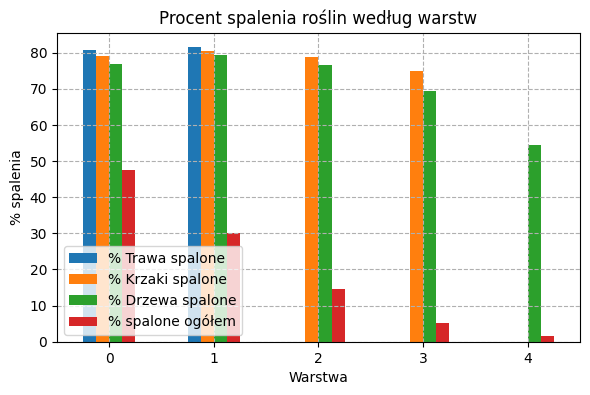

In [354]:
df_result.plot(x='Layer', y=[col for col in df_result.columns if "spalone" in col], kind='bar', figsize=(6,4))
plt.title("Procent spalenia roślin według warstw")
plt.ylabel("% spalenia")
plt.xlabel("Warstwa")
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.legend(loc='lower left')
plt.savefig("plot_burned_3d.png")
plt.xticks(rotation=360)
plt.show()